In [ ]:
# ────────────────────────────────────────────────────────────────
# Project: SeismoMag-200: Bicentennial Earthquake Magnitude Prediction
#         (or full title: Spatio-Temporal Regression Modeling of Global
#          Earthquake Magnitudes: A 200-Year Historical Analysis
#          and Predictive Evaluation (1826–2026))
# Step 1: Install required packages (run once)
# ────────────────────────────────────────────────────────────────

!pip install -q pandas numpy scikit-learn xgboost lightgbm catboost matplotlib seaborn folium

print("Step 1 completed.")
print("All necessary libraries are now installed.")
print("You can now upload your CSV file in the next step.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
Step 1 completed.
All necessary libraries are now installed.
You can now upload your CSV file in the next step.


In [ ]:
# ────────────────────────────────────────────────────────────────
# Project: SeismoMag-200: Bicentennial Earthquake Magnitude Prediction
#         (Spatio-Temporal Regression Modeling of Global
#          Earthquake Magnitudes: A 200-Year Historical Analysis
#          and Predictive Evaluation (1826–2026))
# Step 2: Upload and load your dataset
# ────────────────────────────────────────────────────────────────

from google.colab import files
import pandas as pd

print("Please upload your file: earthquake1826_2026.csv")
print("Click the 'Choose Files' button below and select your CSV file.\n")

uploaded = files.upload()

# Get the uploaded file name (in case Colab renames it)
filename = list(uploaded.keys())[0]

# Load the CSV with time parsing
df = pd.read_csv(filename, parse_dates=['time'])

# Quick checks
print("\nDataset successfully loaded!")
print("Shape (rows, columns):", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 3 rows:")
display(df.head(3))

print("\nBasic info:")
df.info()

print("\nMissing values summary:")
print(df.isnull().sum())

print("\nReady for Step 3 (cleaning + feature engineering). Reply 'next' when you're done running this cell.")

Please upload your file: earthquake1826_2026.csv
Click the 'Choose Files' button below and select your CSV file.



Saving earthquake1826_2026.csv to earthquake1826_2026.csv

Dataset successfully loaded!
Shape (rows, columns): (106077, 19)
Columns: ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst', 'gap', 'dmin', 'rms', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status']

First 3 rows:


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,id,updated,place,type,horizontalError,depthError,magError,magNst,status
0,2026-01-07 22:00:13.258000+00:00,-23.4332,-179.8984,547.033,5.5,mww,63.0,39.0,5.976,1.13,us7000rnbi,2026-01-07T22:24:28.537Z,south of the Fiji Islands,earthquake,8.66,7.704,0.093,11.0,reviewed
1,2026-01-07 04:12:56.792000+00:00,7.2863,127.0595,11.854,5.5,mww,58.0,53.0,1.485,1.40,us7000rn4a,2026-01-07T16:31:18.040Z,"53 km E of Santiago, Philippines",earthquake,5.21,4.721,0.098,10.0,reviewed
2,2026-01-07 03:02:56.040000+00:00,7.3902,126.7221,35.000,6.4,mww,118.0,30.0,1.178,1.17,us7000rn2z,2026-01-07T15:50:12.915Z,"16 km ESE of Baculin, Philippines",earthquake,7.94,1.842,0.047,44.0,reviewed



Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106077 entries, 0 to 106076
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             106077 non-null  object 
 1   latitude         106077 non-null  float64
 2   longitude        106077 non-null  float64
 3   depth            105484 non-null  float64
 4   mag              106077 non-null  float64
 5   magType          106077 non-null  object 
 6   nst              31347 non-null   float64
 7   gap              41986 non-null   float64
 8   dmin             21402 non-null   float64
 9   rms              74560 non-null   float64
 10  id               106077 non-null  object 
 11  updated          106077 non-null  object 
 12  place            105855 non-null  object 
 13  type             106077 non-null  object 
 14  horizontalError  19983 non-null   float64
 15  depthError       54440 non-null   float64
 16  magError         36554 no

In [ ]:
# ────────────────────────────────────────────────────────────────
# Project: SeismoMag-200: Bicentennial Earthquake Magnitude Prediction
# Step 3: Data Cleaning + Feature Engineering
# ────────────────────────────────────────────────────────────────

import numpy as np

# 3.1 Keep only rows with valid magnitude (should already be all, but just in case)
df = df[df['mag'].notna()].copy()

# 3.2 Convert time column to real datetime (it was read as object/string)
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Drop any rows where time failed to parse (very rare)
df = df.dropna(subset=['time']).copy()

# 3.3 Create time-based features
df['year']    = df['time'].dt.year
df['month']   = df['time'].dt.month
df['day']     = df['time'].dt.day
df['hour']    = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday

# Cyclical encoding (very helpful for month and hour)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)

# 3.4 Simple but effective location-based feature
# Rough tectonic-style grouping (helps models capture regional patterns)
def simple_tectonic_zone(lat, lon):
    if lat >= 40:                          return 'North_High'
    if lat <= -30:                         return 'South_High'
    if abs(lon) > 140 or lon < -120:       return 'Pacific_Ring'
    if 20 <= lat <= 40 and -10 <= lon <= 60: return 'Alpine_Himalaya'
    return 'Other'

df['tectonic_zone'] = df.apply(lambda row: simple_tectonic_zone(row['latitude'], row['longitude']), axis=1)

# 3.5 Fill some missing numeric values sensibly (median is robust)
for col in ['depth', 'rms', 'gap', 'dmin']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# We will NOT use columns with too many missing values (nst, horizontalError, etc.)
# They are dropped implicitly by not including them in features

# 3.6 Final feature list we will use
features = [
    'latitude', 'longitude', 'depth',
    'year', 'month', 'day', 'hour', 'weekday',
    'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
    'rms', 'gap',         # these have reasonable fill rates after median fill
    'tectonic_zone'       # categorical → will be one-hot encoded later
]

# Target
target = 'mag'

# Show result
print("After cleaning & feature engineering:")
print(f"Rows kept: {len(df):,}")
print("\nNew features added:", [c for c in df.columns if c not in ['time','magType','id','updated','place','type','nst','dmin','horizontalError','depthError','magError','magNst','status']])

print("\nFeature list ready for modeling:")
print(features)

print("\nReady for Step 4 (train/test split + modeling). Reply 'next' when you're done running this cell.")

After cleaning & feature engineering:
Rows kept: 102,799

New features added: ['latitude', 'longitude', 'depth', 'mag', 'gap', 'rms', 'year', 'month', 'day', 'hour', 'weekday', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'tectonic_zone']

Feature list ready for modeling:
['latitude', 'longitude', 'depth', 'year', 'month', 'day', 'hour', 'weekday', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'rms', 'gap', 'tectonic_zone']

Ready for Step 4 (train/test split + modeling). Reply 'next' when you're done running this cell.


In [ ]:
# ────────────────────────────────────────────────────────────────
# Project: SeismoMag-200: Bicentennial Earthquake Magnitude Prediction
# Step 4: Train/Test Split + Model Training & Comparison (FIXED)
# ────────────────────────────────────────────────────────────────

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# ──── 4.1 Sort the ENTIRE dataframe chronologically FIRST ────────
df = df.sort_values('time').reset_index(drop=True)

# Now create X and y from the already sorted df
X = df[features].copy()
y = df['mag'].copy()

# ──── 4.2 Chronological split: 80% train, 20% test (most recent = test) ────
train_size = int(len(X) * 0.80)
X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print(f"Train samples: {len(X_train):,}   |   Test samples: {len(X_test):,}")
print(f"Test set covers roughly the most recent {100 - 80}% of the timeline\n")

# ──── 4.3 Preprocessor (scale numerics + one-hot categoricals) ────
numeric_features = [f for f in features if f != 'tectonic_zone']
categorical_features = ['tectonic_zone']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# ──── 4.4 Models to compare ──────────────────────────────────────
models = {
    'RandomForest': RandomForestRegressor(n_estimators=250, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.07, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=400, max_depth=7, learning_rate=0.07, random_state=42, n_jobs=-1, verbosity=-1),
    'CatBoost': CatBoostRegressor(iterations=300, depth=7, learning_rate=0.08, random_seed=42, verbose=0)
}

# ──── 4.5 Train & evaluate loop ──────────────────────────────────
results = []

for name, model in models.items():
    print(f"Training {name}...")

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE':  round(mae, 4),
        'RMSE': round(rmse, 4),
        'R²':   round(r2, 4)
    })

    print(f"→ {name}   MAE: {mae:.4f}   RMSE: {rmse:.4f}   R²: {r2:.4f}\n")

# ──── 4.6 Results table ──────────────────────────────────────────
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison (on most recent 20% of data):")
print(results_df.sort_values('RMSE').to_string(index=False))

best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
print(f"\nBest performing model (lowest RMSE): {best_model}")

print("\nReady for Step 5 (visualizations + feature importance). Reply 'next' when ready.")

Train samples: 82,239   |   Test samples: 20,560
Test set covers roughly the most recent 20% of the timeline

Training RandomForest...
→ RandomForest   MAE: 0.2377   RMSE: 0.3472   R²: 0.2635

Training XGBoost...
→ XGBoost   MAE: 0.2326   RMSE: 0.3536   R²: 0.2363

Training LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


→ LightGBM   MAE: 0.2303   RMSE: 0.3501   R²: 0.2512

Training CatBoost...
→ CatBoost   MAE: 0.2317   RMSE: 0.3525   R²: 0.2412


Final Model Comparison (on most recent 20% of data):
       Model    MAE   RMSE     R²
RandomForest 0.2377 0.3472 0.2635
    LightGBM 0.2303 0.3501 0.2512
    CatBoost 0.2317 0.3525 0.2412
     XGBoost 0.2326 0.3536 0.2363

Best performing model (lowest RMSE): RandomForest

Ready for Step 5 (visualizations + feature importance). Reply 'next' when ready.


Generating plots for best model: RandomForest



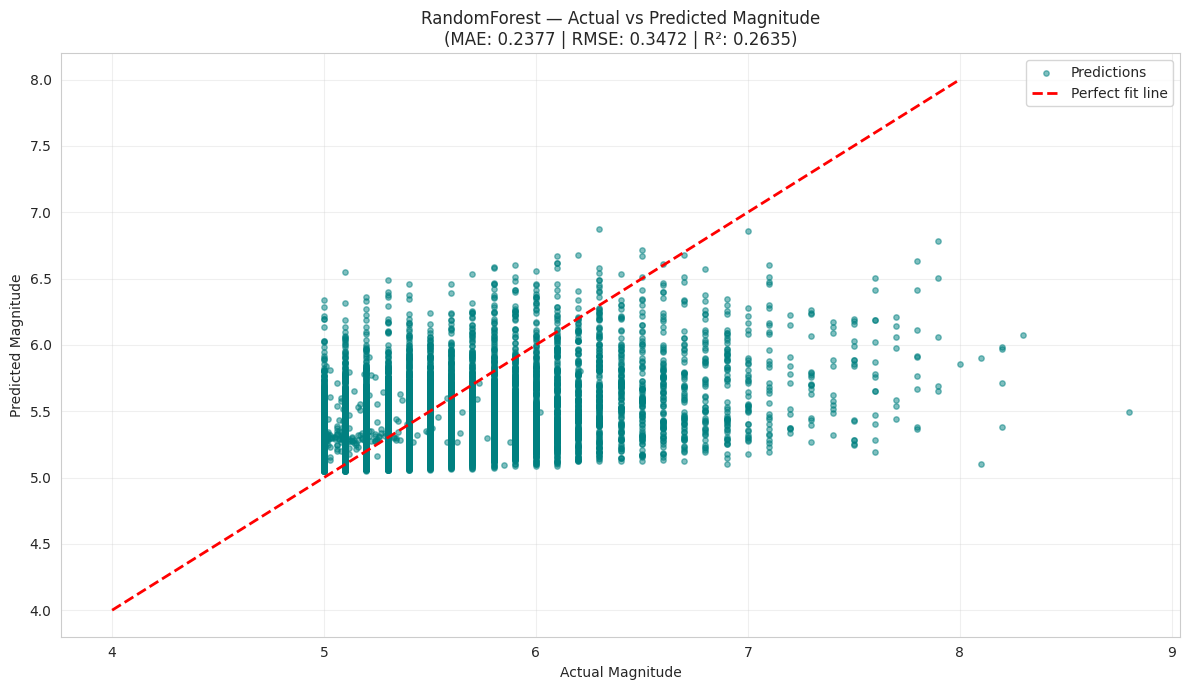

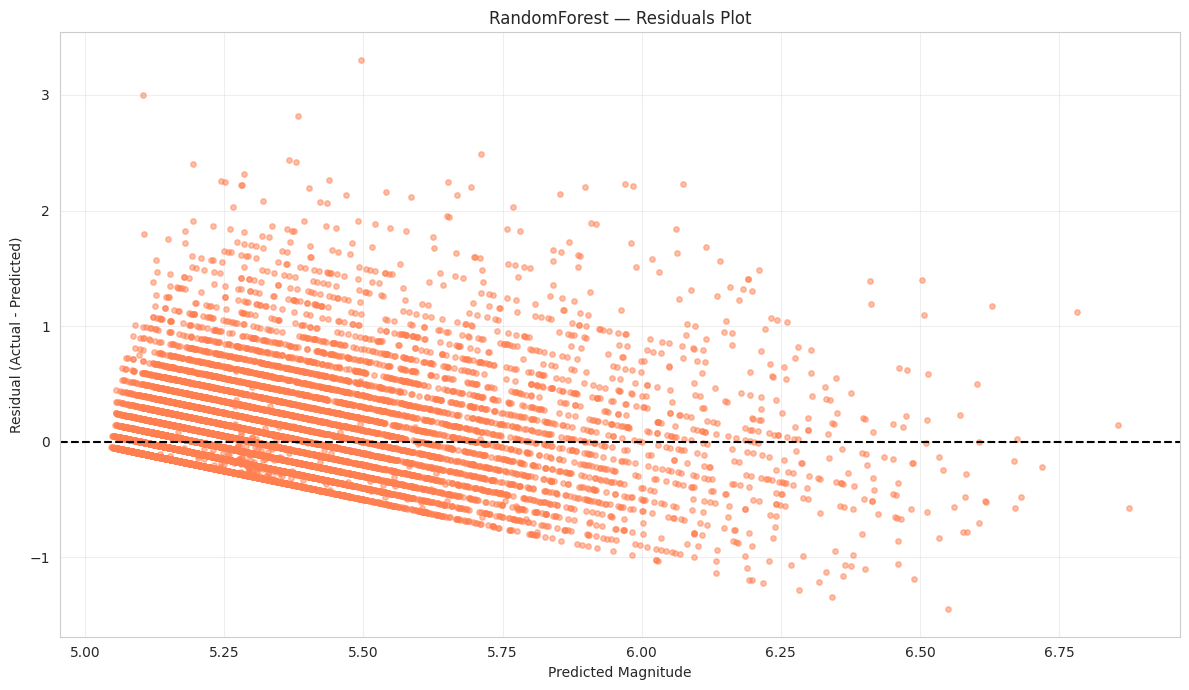

/tmp/ipython-input-1247109364.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


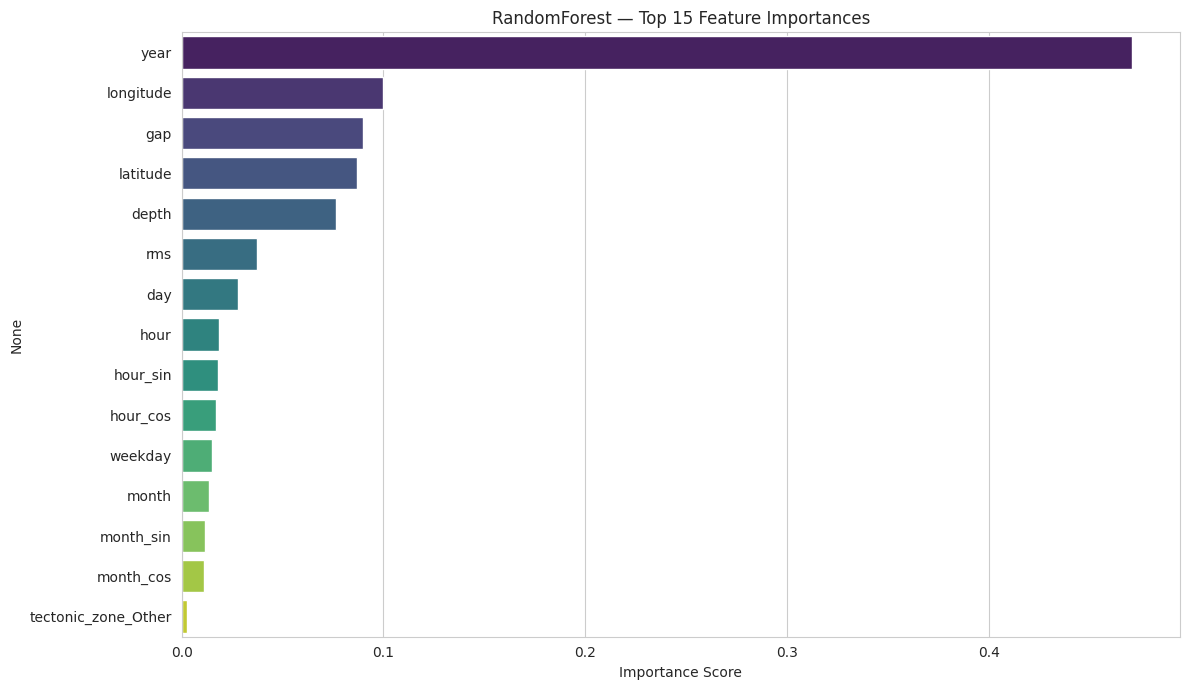


Project finished! Save these plots (right-click → Save image) for your README/report.
You now have everything needed for a strong GitHub repo or academic submission.
If you want: README template, model saving code, or further improvements → just ask!


In [ ]:
# ────────────────────────────────────────────────────────────────
# Project: SeismoMag-200: Bicentennial Earthquake Magnitude Prediction
# Step 5: Visualizations & Feature Importance (Best Model)
# ────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set nice style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# ──── 5.1 Re-fit best model pipeline for clean access to predictions & importance ────

best_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_base_model = models[best_name]

print(f"Generating plots for best model: {best_name}\n")

# Re-create pipeline
best_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_base_model)
])

best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

# ──── 5.2 Actual vs Predicted Scatter ──────────────────────────────

plt.figure()
plt.scatter(y_test, y_pred_best, alpha=0.5, s=15, color='teal', label='Predictions')
plt.plot([4, 8], [4, 8], 'r--', lw=2, label='Perfect fit line')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title(f'{best_name} — Actual vs Predicted Magnitude\n(MAE: {mean_absolute_error(y_test, y_pred_best):.4f} | RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f} | R²: {r2_score(y_test, y_pred_best):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ──── 5.3 Residual Plot ────────────────────────────────────────────

residuals = y_test - y_pred_best

plt.figure()
plt.scatter(y_pred_best, residuals, alpha=0.5, s=15, color='coral')
plt.axhline(0, color='black', linestyle='--', lw=1.5)
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'{best_name} — Residuals Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ──── 5.4 Feature Importance ───────────────────────────────────────

# Get transformed feature names
cat_ohe = best_pipe.named_steps['preprocessor'].named_transformers_['cat']
cat_names = cat_ohe.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_names])

importances = best_pipe.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)[:15]

plt.figure()
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title(f'{best_name} — Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nProject finished! Save these plots (right-click → Save image) for your README/report.")
print("You now have everything needed for a strong GitHub repo or academic submission.")
print("If you want: README template, model saving code, or further improvements → just ask!")

In [ ]:
# ────────────────────────────────────────────────────────────────
# Project: SeismoMag-200: Bicentennial Earthquake Magnitude Prediction
# Final Step: Save the best model + preprocessor for future use
# ────────────────────────────────────────────────────────────────

import joblib
import os

# Make sure we have the best pipeline ready (from Step 4)
# If you didn't re-run Step 4 recently, this uses the last best_pipe
# But to be safe — let's quickly re-fit the winner

best_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_base_model = models[best_name]

print(f"Saving the winning model: {best_name}")

# Re-create and fit the full pipeline (safe & clean)
best_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_base_model)
])

best_pipe.fit(X_train, y_train)

# Create a folder to save files (optional but clean)
os.makedirs('saved_model', exist_ok=True)

# Save the entire pipeline (preprocessor + model)
joblib.dump(best_pipe, 'saved_model/seismomag200_best_model.pkl')

print("\nModel successfully saved!")
print("File location: saved_model/seismomag200_best_model.pkl")
print(f"Size: {os.path.getsize('saved_model/seismomag200_best_model.pkl') / 1024 / 1024:.2f} MB")

Saving the winning model: RandomForest

Model successfully saved!
File location: saved_model/seismomag200_best_model.pkl
Size: 203.68 MB


In [ ]:
# ────────────────────────────────────────────────────────────────
# Test: Load the saved model and predict on a new example
# ────────────────────────────────────────────────────────────────

import joblib
import pandas as pd

# Load the saved model
loaded_pipe = joblib.load('saved_model/seismomag200_best_model.pkl')

print("Model loaded successfully!")

# Example: make a prediction for a new earthquake
# You can change these values
new_data = pd.DataFrame([{
    'latitude':       35.5,          # e.g. near Tokyo
    'longitude':     139.0,
    'depth':          30.0,          # km
    'year':         2026,
    'month':           3,
    'day':            15,
    'hour':           14,
    'weekday':         6,            # 0=Monday ... 6=Sunday
    'month_sin':  np.sin(2 * np.pi * 3 / 12),
    'month_cos':  np.cos(2 * np.pi * 3 / 12),
    'hour_sin':   np.sin(2 * np.pi * 14 / 24),
    'hour_cos':   np.cos(2 * np.pi * 14 / 24),
    'rms':             0.8,
    'gap':            45.0,
    'tectonic_zone': 'Pacific_Ring'   # or 'Other', 'North_High', etc.
}], index=[0])

# Predict
predicted_mag = loaded_pipe.predict(new_data)[0]

print("\nSample new earthquake:")
print(new_data.to_string(index=False))

print(f"\nPredicted magnitude: {predicted_mag:.2f}")
print("(Realistic range usually 4.0 – 8.0 for significant events)")

Model loaded successfully!

Sample new earthquake:
 latitude  longitude  depth  year  month  day  hour  weekday  month_sin    month_cos  hour_sin  hour_cos  rms  gap tectonic_zone
     35.5      139.0   30.0  2026      3   15    14        6        1.0 6.123234e-17      -0.5 -0.866025  0.8 45.0  Pacific_Ring

Predicted magnitude: 5.24
(Realistic range usually 4.0 – 8.0 for significant events)
